# Testing Model Performance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.append('/media/jayanth/New Volume/time_series_modeling/ppg_dalia_heartrate_estimation/')

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [5]:
import tensorflow as tf
from src.models.define_model import cnnLSTMModel

#### define a function to build the model

In [6]:
def build_model():
    model = cnnLSTMModel(n_conv_layers=2,n_conv_filters=20,kernel_size=4,n_lstm_units=64,n_dense_nodes=32,n_output_nodes=1,input_shape=(None,8,8))
    return model

In [7]:
from src.features.build_features import to_supervised

In [8]:
from pickle import load

In [9]:
def reshape(X):
    return X.reshape(
            (X.shape[0], 1, 8, 8)
        )

In [10]:
from sklearn.metrics import mean_absolute_error

### define a function to create plots 

In [11]:
def plotter_func(subject):
    # create a model object
    model = build_model()
    # load saved weights
    model = tf.keras.models.load_model('../models/ckpoints/model_{}'.format(subject))
    # load scaler
    scaler = load(open("../models/scaler_and_encoder_{}.pkl".format(subject), "rb")) 
    # load data
    data = pd.read_csv('../data/interim/S{0}/S{0}.csv'.format(subject),index_col=0)
    # transform data
    df = scaler.transform(data)
    X,y = to_supervised(np.array(df),8,1)
    X = reshape(X)
    # get predictions
    yhat = model.predict(X)   
    # create plots
    time = np.linspace(0,len(y)//8,len(y))
    fig,ax = plt.subplots(figsize=(20,10))
    plt.plot(time,y,'-k',label='ground_truth')
    plt.plot(time,yhat,':r',label='predictions')
    plt.xlabel('time (s)')
    plt.ylabel('heart rate (bpm)')
    plt.title('model predictions for subject - {}'.format(subject))
    # plt.xlim([3000,4000])
    plt.legend()
    plt.show()

### define a function to calculate mae for each test subject

In [14]:
def mae_summary():
    # create list of subjects
    subjects = list(range(1,16))
    # create a summary dict
    summary = dict()
    # iterate through each subject
    for sub in subjects:
        # create a model object
        model = build_model()
        # load saved weights
        model = tf.keras.models.load_model('../models/ckpoints/model_{}'.format(sub))
        # load scaler
        scaler = load(open("../models/scaler_and_encoder_{}.pkl".format(sub), "rb")) 
        # load data
        data = pd.read_csv('../data/interim/S{0}/S{0}.csv'.format(sub),index_col=0)
        # transform data
        df = scaler.transform(data)
        X,y = to_supervised(np.array(df),8,1)
        X = reshape(X)
        # get predictions
        yhat = model.predict(X)
        # print mae
        mae = mean_absolute_error(y,yhat)
        # populate dictionary
        summary[sub] = mae
    
    # convert summary dictionary into a dataframe
    summary = pd.DataFrame.from_dict(summary,orient='index',columns=['score'])
    
    return summary

In [15]:
summary = mae_summary()
summary.head(15)

,score
1,9.992168
2,7.796491
3,12.444790
4,9.892316
5,43.913243
6,25.697682
7,12.398384
8,14.125384
9,10.164914
10,11.020156


In [16]:
average_mae = np.mean(summary['score'].values)
average_mae

15.443486027545609

### create plots

plot the performance of the model for the subject with the lowest mae score

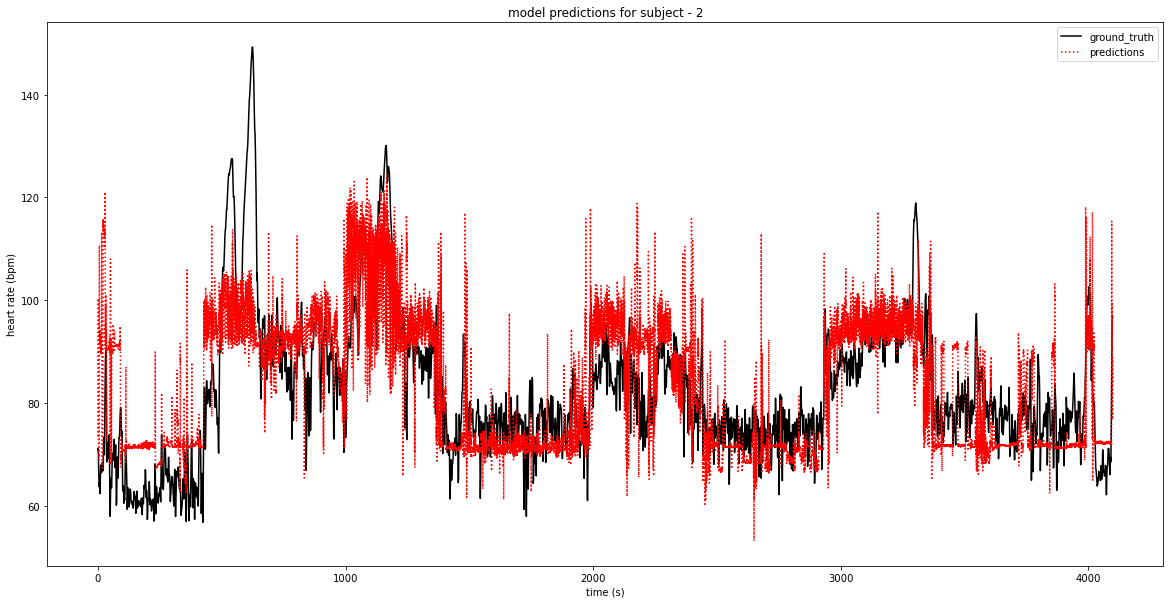

In [18]:
plotter_func(2)

the model seems to be able to track the general movement of trend of the heart rate even though the peaks are not captured properly

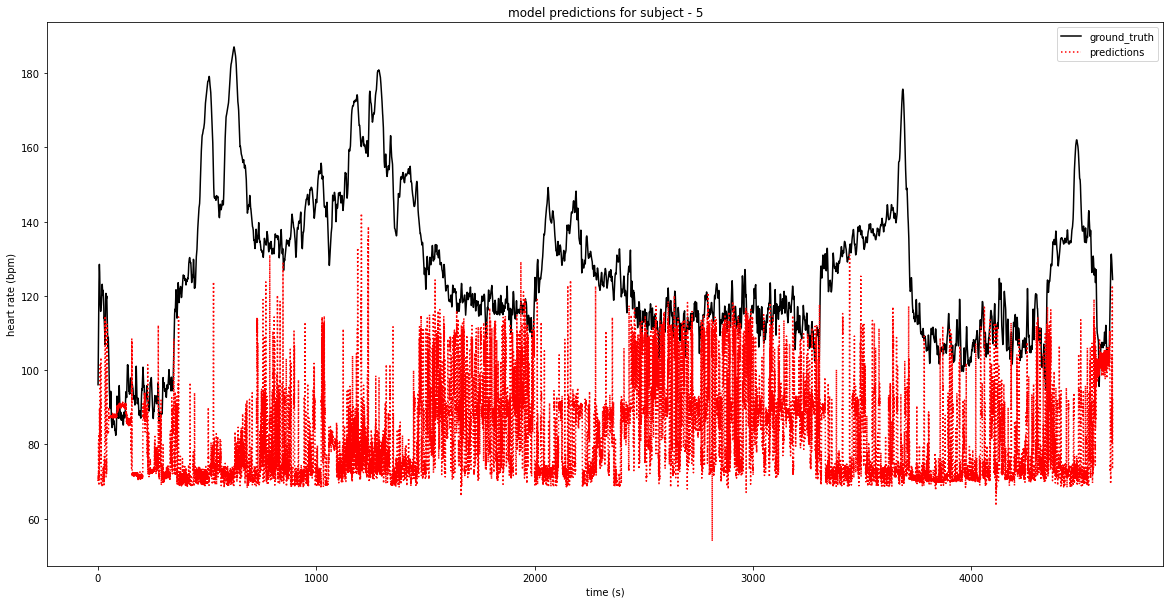

In [19]:
plotter_func(5)

the model seems to not be able to track the movement of heart rate and the model severely under-predicts the heart rate. according to the data set description, this subject is an outlier with a higher baseline heart rate than other subjects, so poor performance on this subject is expected